Imports.

In [1]:
import os, sys, codecs
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline 

Download GloVe dataset if it doesn't already exist.

In [2]:
def download_data():
    pass

if not os.path.exists('../data/glove/glove.6B.300d.txt'):
    print('GloVe data not found, downloading (this could take a while)...')
    if os.system('../download_GloVe_data.sh') == 0:
        print('Downloaded data successfully.')
    else:
        print('Download failed, try to download manually using download_GloVe_data.sh script.')
        

Parse the GloVe dataset and build the word embeddings matrix as well as the label list.

In [3]:
def build_word_vector_matrix(vector_file, n_words):
    '''Read a GloVe array from sys.argv[1] and return its vectors and labels as arrays'''
    np_arrays = []
    labels_array = []

    with codecs.open(vector_file, 'r', 'utf-8') as f:
        for i, line in enumerate(f):
            sr = line.split()
            labels_array.append(sr[0])
            np_arrays.append(np.array([float(j) for j in sr[1:]]))
            if i == n_words - 1:
                return np.array(np_arrays), labels_array
            
# parse data and create embedding matrix and labels array
embeddings, labels = build_word_vector_matrix('../data/glove/glove.6B.300d.txt', 10000)

# create dictionaries from labels array for quick lookups
id_to_word = dict(zip(range(len(labels)), labels))
word_to_id = dict((v,k) for k,v in id_to_word.items())

Apply k-means with k clusters.

In [4]:
k = 100 # number of clusters
# Create KMeans model using all CPUs
kmeans_model = KMeans(init='k-means++', n_clusters=k, n_jobs=-1, n_init=10)
print('Running K-means clustering algorithm...')
kmeans_model.fit(embeddings)
print('Done.')

cluster_labels  = kmeans_model.labels_
cluster_inertia = kmeans_model.inertia_

Running K-means clustering algorithm...
Done.


Create `clusters` list and populate each element with the words from that cluster.

In [5]:
uniq_labels = list(set(cluster_labels))
# below expression is a nifty way to create 
# an array consisting of k empty arrays
clusters = [[] for _ in range(len(uniq_labels))]

print('{} labels created'.format(len(cluster_labels)))
print('{} unique labels'.format(len(clusters)))

for i, label in enumerate(cluster_labels):
    clusters[int(label)].append(id_to_word[i])


10000 labels created
100 unique labels


Print three random words from each cluster to help and identify the subject of the cluster.

In [6]:
# print three words from each cluster to get an idea 
# of what what that cluster might represent
print('CLUSTER INDEX             RANDOM WORDS FROM CLUSTER')
print('----------------------------------------------------------')
for i, cluster in enumerate(clusters):
    indexes = list(set([randint(0, len(cluster)) - 1 for _ in range(0, 3)]))
    words = [cluster[index] for index in indexes]
    print('#{}'.format(str(i).ljust(3)), *list(map(lambda w: w.rjust(17), words)))

CLUSTER INDEX             RANDOM WORDS FROM CLUSTER
----------------------------------------------------------
#0          transition           repairs         initiated
#1                alex             kevin               dan
#2                 2.5               4.2               1.3
#3                 fcc          immunity             judge
#4              remove             plans            enable
#5             outside           bedroom               wet
#6           directing             drama               pbs
#7            africans             ghana          thailand
#8                  50                94                kg
#9                1993             1950s              1979
#10            skilled        enthusiasm        indication
#11        constructed             built          removing
#12            150,000                 $               300
#13               bath         edinburgh         tottenham
#14            holiday          blessing          birthday
#15 

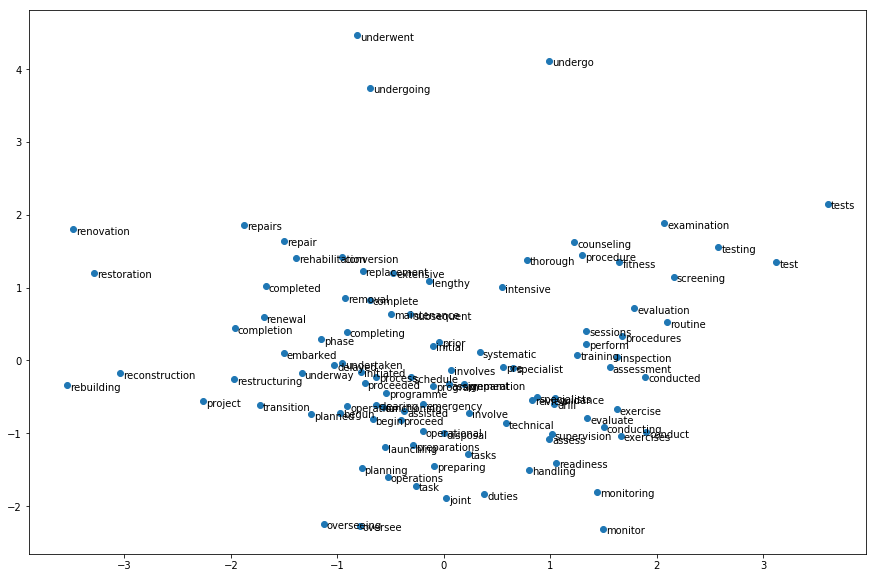

In [7]:
def fit_and_plot_pca(cluster):
    
    # extract the embeddings of only the words in the cluster
    indicies = [word_to_id[word] for word in cluster]
    cluster_embeddings = [embeddings[index] for index in indicies]

    pca = PCA(n_components=2)
    pca.fit(cluster_embeddings)
    reduced_dim = pca.transform(cluster_embeddings)
    # print(pca.explained_variance_ratio_)

    xs = reduced_dim[:, 0]
    ys = reduced_dim[:, 1]
    fig = plt.figure(figsize=(15, 10))
    plt.scatter(xs, ys, marker = 'o')
    for i, word in enumerate(cluster):
         plt.annotate(
             word,
             xy = (xs[i], ys[i]), xytext = (3, 3),
             textcoords = 'offset points', ha = 'left', va = 'top')
    
cluster = clusters[0] # select an index from the list above to visualize with PC
fit_and_plot_pca(cluster)
## Uncomment below to plot all k clusters
## WARNING: This can use a LOT of memory
# for i, cluster in enumerate(clusters):
#    fit_and_plot_pca(cluster)
